# Putting everything together


### 0.1. Importing pytorch

In [25]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
is_in_colab = input("Is the model being trained in a colab environment(y/n)?\n:")
if (is_in_colab.lower()=="y"):
  import google.colab
print(f"Imported Torch v{torch.__version__}")

Imported Torch v2.1.1+cu118


### 0.2. Device Agnostic code

The major advantage of using a system equipped with a GPU is the ability of Tensors to be stored in the gpu and operated on by them. GPUs have large number of cored and albeit low power, can crunch to large amount of data rapidly. But it is not always guaranteed that the system where we are training our data is equipped a gpu. In that case we setup a device agnostic code that sets the device of our tensors as per the availability. 

While it is suggested to train our model in a system that is equipped with a dedicated gpu (usually CUDA cores). We may have to test our model's trainability or framework before it send it to get trained. In such situations running a preliminary training run on small amount of data to determine the efficiency can eliminate the need to attempt long failed runs repeatedly.

In [14]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Data

### 1.1. Preparing data for training and testing

In [15]:
# Preparing arbitrary parameters
weight = 0.6 
bias = 0.2
start = 0
end = 1
step = 0.01
X = torch.arange(start, end, step).unsqueeze(dim=1)
# Not unsqueezing can cause errors
Y = weight * X + bias

### 1.2. Splitting our data into training and testing sets

In [16]:
train_split = int(0.6*len(X))
train_val_split = int(0.8*len(X))
X_train = X[:train_split]
X_test = X[train_val_split:]
Y_train = Y[:train_split]
Y_test = Y[train_val_split:]
X_val = X[train_split:train_val_split]
Y_val = Y[train_split:train_val_split]

### 1.3. Visualization

In [17]:
def plot_predictions(train_data = X_train.to("cpu"),
                     train_labels = Y_train.to("cpu"),
                     val_data = X_val.to("cpu"),
                     val_labels = Y_val.to("cpu") ,
                     test_data = X_test.to("cpu"), 
                     test_labels = Y_test.to("cpu"), 
                     predictions = None):
  plt.figure(figsize=(10,7)) # Figure dimensions in inches

  # (<data-x>, <data-y>, <color>, <scale>, <label>)
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data") 
  plt.scatter(val_data, val_labels, c = "r", s=4, label="Validation Data")
  plt.scatter(test_data, test_labels, c="orange", s=4, label="Test Data")

  if predictions is not None:
    # Plot the predictions
    plt.scatter(test_data, predictions, c="black", s=4, label="Predictions")

  plt.legend(prop={"size" : 14}); # (<property dictionary>)

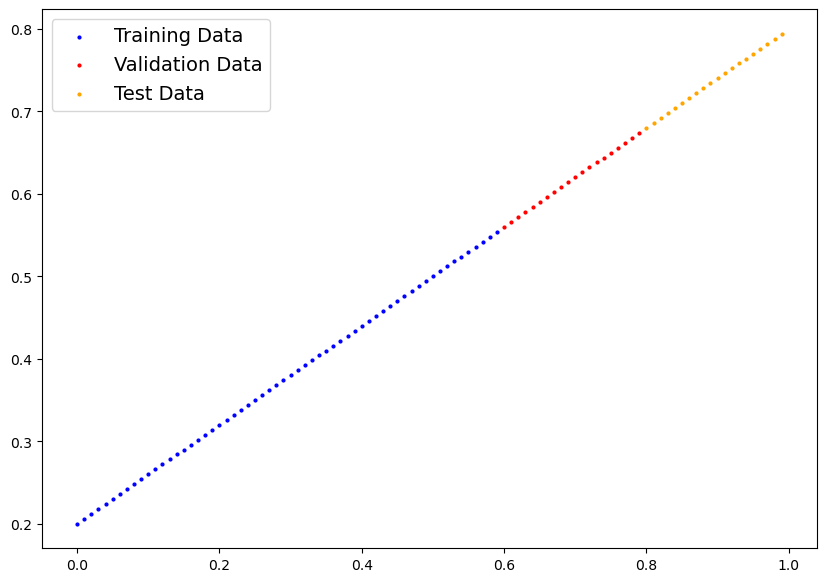

In [18]:
plot_predictions()

## 2. Building the Model

### 2.1. Defining the model by inheriting torch.nn.Module class

In [19]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Using nn.Linear for creating model parameters
    self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
  def forward(self, x : torch.Tensor)-> torch.Tensor:
    return self.linear_layer(x)

### 2.2. Creating a model instance, seeding the RNG for reproduciblity

In [20]:
torch.manual_seed(69)
model = LinearRegressionModel()
model.state_dict()

# Checking the device accessing the model
next(model.parameters())

# Sending the model to the available device (cuda preferred)
model.to(device)

OrderedDict([('linear_layer.weight', tensor([[0.6796]])),
             ('linear_layer.bias', tensor([0.6083]))])

Parameter containing:
tensor([[0.6796]], requires_grad=True)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

### 2.3. Loss Function and Optimizer

In [21]:
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.001)

### 2.4. Training Loop and Testing Loop

In [22]:
def train_model(tr_model = model, tr_features = X_train, tr_labels = Y_train, va_features = X_val, va_labels = Y_val, epochs = 10, opt = optimizer, loss = loss_function):
  # Training metrics
  epoch_c = []
  loss_val = []
  test_loss_val = []
  # Training
  time_start = time.time()
  for epoch in range(1, epochs+1):
    model.train()
    Y_preds_tr = tr_model(tr_features)
    tr_loss = loss(Y_preds_tr, tr_labels)
    opt.zero_grad()
    tr_loss.backward()
    opt.step()
    # Testing
    if epoch % 10 == 0:
      Y_preds_te = tr_model(va_features)
      te_loss = loss(Y_preds_te, va_labels)
      epoch_c.append(epoch)
      loss_val.append(tr_loss.item())
      test_loss_val.append(te_loss.item())
      print(f"Epoch: {epoch} | Weight: {model.linear_layer.weight.item()} | Bias: {model.linear_layer.bias.item()}\nLoss: {tr_loss} | Validation Loss: {te_loss}")
  time_end = time.time()
  print(f"Time Elapsed: {time_end - time_start}")
  return epoch_c, loss_val, test_loss_val
  
  

In [23]:
epoch_count, loss_v, test_loss_v = train_model(epochs=670)

Epoch: 10 | Weight: 0.6766220331192017 | Bias: 0.5983006954193115
Loss: 0.421991229057312 | Validation Loss: 0.45155301690101624
Epoch: 20 | Weight: 0.6736721992492676 | Bias: 0.5883008241653442
Loss: 0.4111211597919464 | Validation Loss: 0.439503014087677
Epoch: 30 | Weight: 0.6707223653793335 | Bias: 0.578300952911377
Loss: 0.4002510607242584 | Validation Loss: 0.4274529814720154
Epoch: 40 | Weight: 0.6677725315093994 | Bias: 0.5683010816574097
Loss: 0.38938096165657043 | Validation Loss: 0.41540297865867615
Epoch: 50 | Weight: 0.6648226976394653 | Bias: 0.5583012104034424
Loss: 0.37851089239120483 | Validation Loss: 0.4033529758453369
Epoch: 60 | Weight: 0.6618728637695312 | Bias: 0.5483013391494751
Loss: 0.36764082312583923 | Validation Loss: 0.3913029432296753
Epoch: 70 | Weight: 0.6589230298995972 | Bias: 0.5383014678955078
Loss: 0.35677072405815125 | Validation Loss: 0.37925294041633606
Epoch: 80 | Weight: 0.6559731960296631 | Bias: 0.5283015966415405
Loss: 0.34590068459510803 |

Epoch: 170 | Weight: 0.6294246912002563 | Bias: 0.43830275535583496
Loss: 0.24807003140449524 | Validation Loss: 0.25875288248062134
Epoch: 180 | Weight: 0.6264748573303223 | Bias: 0.4283028841018677
Loss: 0.23719997704029083 | Validation Loss: 0.2467029094696045
Epoch: 190 | Weight: 0.6235250234603882 | Bias: 0.4183030128479004
Loss: 0.22632987797260284 | Validation Loss: 0.23465284705162048
Epoch: 200 | Weight: 0.6205751895904541 | Bias: 0.4083031415939331
Loss: 0.21545982360839844 | Validation Loss: 0.22260288894176483
Epoch: 210 | Weight: 0.61762535572052 | Bias: 0.3983032703399658
Loss: 0.20458973944187164 | Validation Loss: 0.2105528861284256
Epoch: 220 | Weight: 0.6146755218505859 | Bias: 0.38830339908599854
Loss: 0.19371967017650604 | Validation Loss: 0.19850286841392517
Epoch: 230 | Weight: 0.6117256879806519 | Bias: 0.37830352783203125
Loss: 0.18284958600997925 | Validation Loss: 0.18645285069942474
Epoch: 240 | Weight: 0.6087758541107178 | Bias: 0.36830365657806396
Loss: 0.1

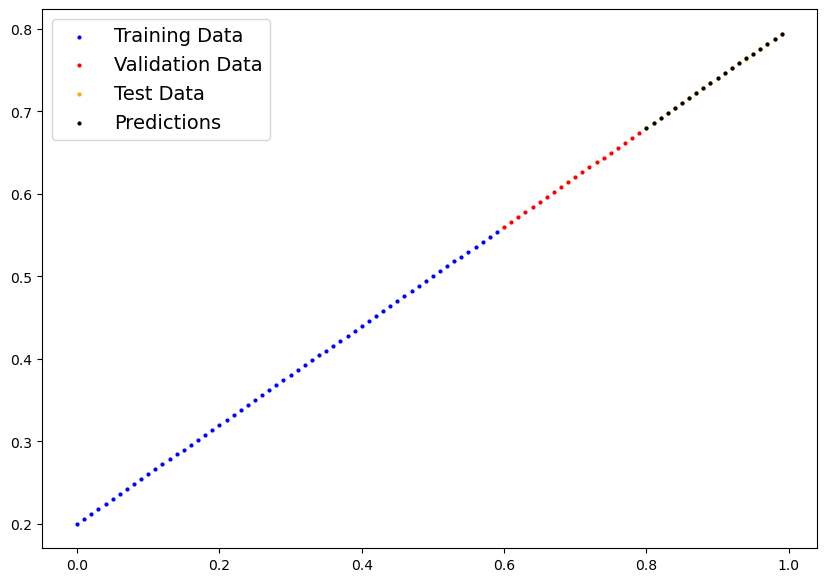

In [24]:
with torch.inference_mode():
  y_preds_te = model(X_test)
  plot_predictions(predictions=y_preds_te)


## 3. Saving and Loading a Trained Model

In [28]:
### 3.1. Saving our trained model

MODEL_NAME = "altogether_model.pth"
PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

if is_in_colab == "y":
  files.download(f"{MODEL_SAVE_PATH}")